In [ ]:
import sys
sys.path.append("..")

from methods.dcbo import DynCausalBayesOpt
from utils.sequential_sampling import draw_samples_from_sem_dev
from causal_graph.example_dyn_graphs import three_step_stat
from sem.stationary import StationaryModel_dev
from collections import OrderedDict
from utils.costs import equal_cost
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from collections import OrderedDict
tfd = tfp.distributions

In [ ]:
sem_model = StationaryModel_dev()
num_samples = 20
temporal_index = 2
full_samples = OrderedDict([(key, []) for key in sem_model.static().keys()])
epsilon = OrderedDict(
    [
        (key, tfd.Normal(0.0, 0.3).sample((num_samples, temporal_index+1)))
        for key in full_samples.keys()
    ]
)

epsilon_x1 = tf.linspace(-5.0, 5.0, num_samples)[:, tf.newaxis]
epsilon_x23 = tfd.Normal(0.0, 0.3).sample((num_samples, 2))
epsilon["X"] = tf.concat([epsilon_x1, epsilon_x23], axis=1)

In [2]:
dyn_graph = three_step_stat()

# D_obs = draw_samples_from_sem_dev(sem_model, 20, 2, seed=1111)
D_obs = draw_samples_from_sem_dev(sem_model, num_samples, temporal_index, epsilon=epsilon)

intervention_ini = {
    "X": [-3.6],
    "Z": [None],
    "Y": [None],
}
D_intervene_ini_x = draw_samples_from_sem_dev(
    sem_model, 1, 0, intervention=intervention_ini, epsilon=0.0
)
intervention_ini = {
    "X": [None],
    "Z": [-4.0],
    "Y": [None],
}
D_intervene_ini_z = draw_samples_from_sem_dev(
    sem_model, 1, 0, intervention=intervention_ini, epsilon=0.0
)
D_intervene_ini = OrderedDict(
    [(("X",), D_intervene_ini_x), (("Z",), D_intervene_ini_z)]
)
intervention_domain = OrderedDict([("X", [-5.0, 5.0]), ("Z", [-5.0, 20.0])])
num_trials = 20
task = "min"
cost_fn = equal_cost
num_anchor_points = 100
num_monte_carlo = 20
jitter = 1e-6
dcbo = DynCausalBayesOpt(
    dyn_graph,
    sem_model,
    D_obs,
    D_intervene_ini,
    intervention_domain,
    num_trials,
    task,
    cost_fn,
    num_anchor_points,
    num_monte_carlo,
    jitter,
)

In [3]:
opt_history = dcbo.run()

Dynamic causal Bayesian optimization at time step 0 is started.
OrderedDict([(('X',), OrderedDict([('X', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3.6]], dtype=float32)>), ('Z', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[36.598232]], dtype=float32)>), ('Y', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.29238433]], dtype=float32)>)])), (('Z',), OrderedDict([('X', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>), ('Z', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[7.5]], dtype=float32)>), ('Y', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.340654]], dtype=float32)>)]))])
OrderedDict([(('X',), OrderedDict([('X', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3.6]], dtype=float32)>), ('Z', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[36.598232]], dtype=float32)>), ('Y', <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.29238433]], dtype=float32)>)])), (('Z',), OrderedDict([('X',

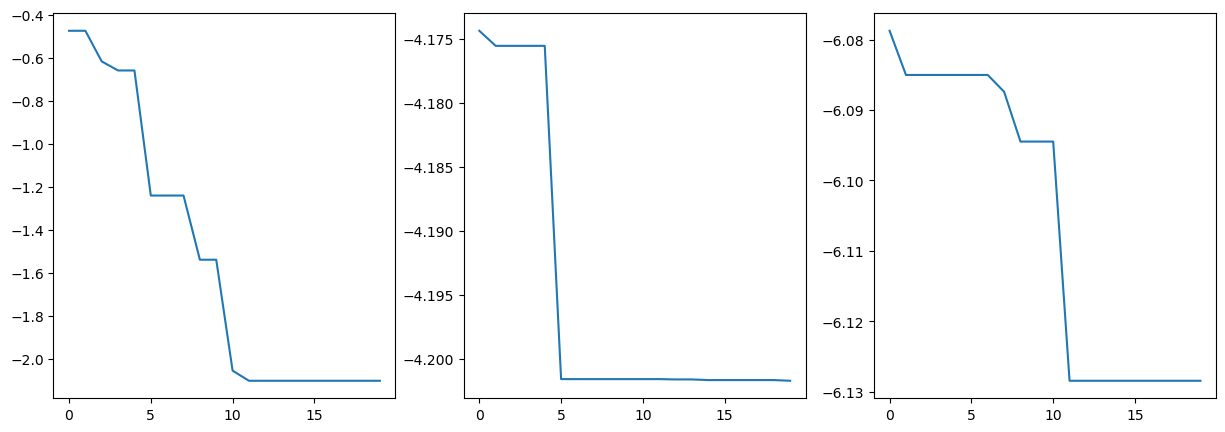

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].plot(opt_history[i])
plt.show()